# Purpose

This notebook serves as a documentation of my work through Chapter 10 of [Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291).  This chapter is an introduction to Artificial Neural Networks (ANN) using Keras and Tensorflow.

# Playground

First and foremost, the [Tensorflow Playground](https://playground.tensorflow.org) is a great place to gain some intuition about how ANNs work.  You can change hyperparameters live and see the effect in real time on the output, training, loss, etc.  You can also view each individual weight and output.  

In [1]:
import tensorflow as tf
from tensorflow import keras

print("tf version:", tf.__version__, ", keras version:", keras.__version__)



2023-01-13 09:16:34.102126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf version: 2.10.0 , keras version: 2.10.0


# Dataset

The [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset will be used throughout these examples.  It is a collection of clothing images that belong to 10 different classes.  It is similar to the more common [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, except it is more complex than hand-written images.  It can be loaded directly from `keras`.

Below, Im loading the dataset, splitting off a validation set, and normalizing the values.  Then, I'm defining the classes and printing out 4 random examples of each class.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

print("Train shape: ", X_train.shape, ", data type: ", X_train.dtype)
print("Valid shape: ", X_valid.shape, ", data type: ", X_valid.dtype)
print("Test shape: ", X_test.shape, ", data type: ", X_test.dtype)



Train shape:  (55000, 28, 28) , data type:  float64
Valid shape:  (5000, 28, 28) , data type:  float64
Test shape:  (10000, 28, 28) , data type:  uint8


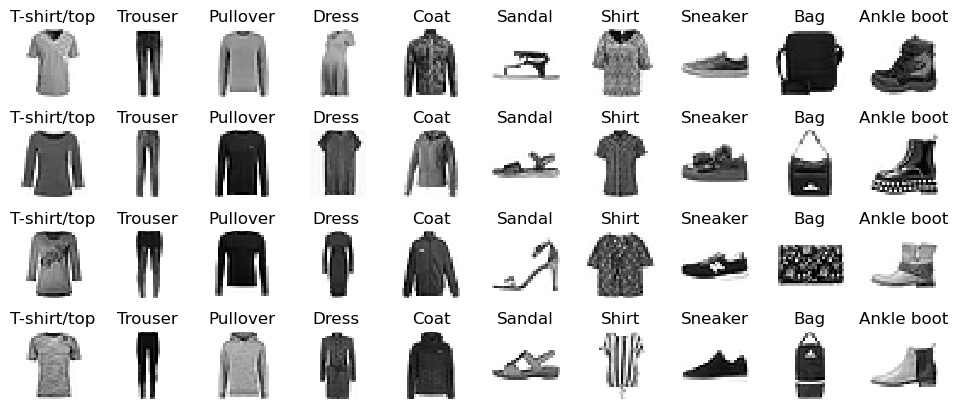

In [29]:
import matplotlib.pyplot as plt
import numpy as np

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

n_rows = 4
n_cols = len(class_names)
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        fig_index = n_cols * row + col + 1
        class_index = col
        X_subset = X_train[y_train == class_index]
        plt.subplot(n_rows, n_cols, fig_index)
        plt.imshow(
            X_subset[np.random.choice(X_subset.shape[0]), :],
            cmap="binary",
            interpolation="nearest",
        )
        plt.axis("off")
        plt.title(class_names[class_index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
# save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()


# Image Classifier using Sequential API